In [1]:
from fastkaggle import *
from fastai import *
from fastai.tabular.all import *
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [2]:
#fastkaggle setup
comp = "store-sales-time-series-forecasting"

path = setup_comp(comp)
path

Path('store-sales-time-series-forecasting')

# Data Setup

In [3]:
holiday_events_df = pd.read_csv(path/'holidays_events.csv', low_memory=False)
oil_df = pd.read_csv(path/'oil.csv')
stores_df = pd.read_csv(path/'stores.csv')
test_df = pd.read_csv(path/'test.csv')
train_df = pd.read_csv(path/'train.csv')
transactions_df = pd.read_csv(path/'transactions.csv')


#correct datetimes
# train_df["date"] = pd.to_datetime(train_df.date)
# test_df["date"] = pd.to_datetime(test_df.date)
# transactions_df["date"] = pd.to_datetime(transactions_df.date)
add_datepart(train_df, 'date')
add_datepart(test_df, 'date')
drop_cols = ['id', 'Elapsed']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

#categorize familys
# train_df['family'] = train_df['family'].astype("category")
# train_df['family'] = train_df.family.cat.codes
train_df['family'] = pd.Categorical(train_df.family)
test_df['family'] = pd.Categorical(test_df.family)


#correct datatypes
# train_df.onpromotion = train_df.onpromotion.astype("float16")
# train_df.sales = train_df.sales.astype("float32")
# stores_df.cluster = stores_df.cluster.astype("int8")

In [4]:
#make validation set from data in yaer 2017. Test set is the last quarter of 2017, so we'll use the first 3 quarters as the validation set
condition = lambda df: (df.Year < 2017)
train_idx = np.where(condition(train_df))[0]
valid_idx = np.where(~(condition(train_df)))[0]
splits = (list(train_idx), list(valid_idx))

In [5]:
#print(train_df.dtypes)

In [13]:
from fastai.tabular.all import *
from numpy import inf
from sklearn.metrics import r2_score
dep_var = 'sales'
#replace dep_var with their logs'
        
train_df[dep_var] = np.log(train_df[dep_var]+1)

conts, cats = cont_cat_split(train_df, 1, dep_var=dep_var)
procs = [Categorify, FillMissing, Normalize]
tc = tabular_config(ps=[0.001, 0.01], embed_p=0.04, y_range=(0, train_df[dep_var].max() / 0.1))
dls = TabularDataLoaders.from_df(train_df, procs=procs, cat_names=cats, cont_names=conts, config=tc, loss_func=MSELossFlat(),
                                  y_names=dep_var, bs=1024, splits=splits, y_block=RegressionBlock(1), shuffle=False, drop_last=True)
learn = tabular_learner(dls, metrics=[rmse])#,r2_score], layers=[300,200,100,50, 1])
dls.show_batch()

,family,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,store_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,sales
0,HOME CARE,False,False,False,False,False,False,32.000000,1.000000e+01,2016.0,11.0,43.999999,4.0,4.000000e+00,309.000004,0.989497
1,GROCERY II,False,False,False,False,False,False,16.000000,5.904722e-08,2013.0,6.0,23.000000,5.0,2.000000e+00,156.000000,0.753653
2,FROZEN FOODS,False,False,False,False,False,False,45.000000,5.904722e-08,2014.0,1.0,2.000001,7.0,1.000000e+00,7.000000,1.061967
3,SEAFOOD,False,False,False,False,False,False,31.000000,5.904722e-08,2013.0,1.0,1.000001,4.0,4.000000e+00,4.000005,0.672503
4,BOOKS,False,False,False,False,False,False,53.000000,5.904722e-08,2014.0,4.0,15.000000,12.0,5.000000e+00,102.000003,0.000000
5,HOME AND KITCHEN I,False,False,False,False,False,False,48.999999,6.000000e+00,2017.0,7.0,27.000000,4.0,1.000000e+00,185.000000,1.003917
6,POULTRY,False,False,False,False,False,False,43.000000,5.904722e-08,2015.0,7.0,29.000000,14.0,1.000000e+00,195.000001,1.021491
7,HOME APPLIANCES,False,False,False,False,False,False,5.000001,5.904722e-08,2013.0,3.0,13.000000,28.0,3.000000e+00,87.000003,0.423036
8,LADIESWEAR,False,False,False,False,False,False,6.999999,5.904722e-08,2014.0,7.0,31.000000,28.0,-6.365657e-08,208.999999,0.798928
9,EGGS,False,False,False,False,False,False,47.000001,5.904722e-08,2015.0,10.0,43.999999,28.0,2.000000e+00,301.000000,1.046353


In [14]:
print(f'Conts: {conts}\n Cats: {cats}\n\n')
print(f'Sales\n\tMax: {dls.train.y.max()}\n\tMin: {dls.train.y.min()}')

Conts: ['store_nbr', 'onpromotion', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
 Cats: ['family', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']


Sales
	Max: 1.2653295993804932
	Min: 0.0


SuggestedLRs(valley=0.002511886414140463, slide=0.003981071524322033)

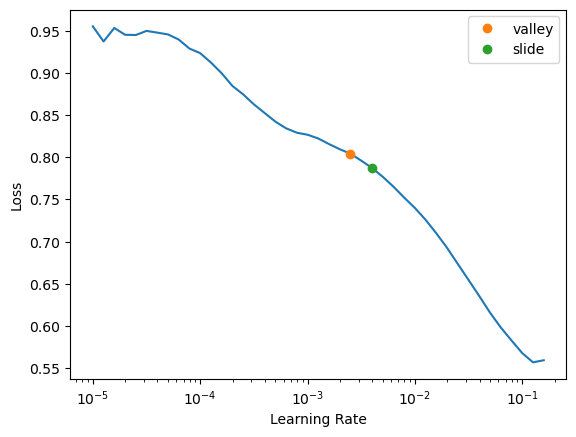

In [15]:
learn.lr_find(suggest_funcs=(valley, slide), start_lr=1e-5, end_lr=1e5, num_it=100)

In [16]:
learn.fit_one_cycle(15, 3e-3, wd=0.2) #todo figure out how to get this a litttttllleee nicer

epoch,train_loss,valid_loss,_rmse,time
0,0.065385,0.065628,0.256180,00:14
1,0.050785,0.055268,0.235091,00:14
2,0.044629,0.050044,0.223705,00:14
3,0.043559,0.045027,0.212196,00:13
4,0.042796,0.045280,0.212790,00:14
5,0.041908,0.050737,0.225249,00:14


KeyboardInterrupt: 

In [17]:
learn.show_results()

,family,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,store_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,sales,sales_pred
0,29.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.507599,2.804769,0.120294,-1.243071,-1.165775,0.496673,0.501899,-1.183477,1.102342,1.044906
1,9.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.250976,-0.212686,0.863539,0.824739,0.794684,0.041874,0.501899,0.837369,1.140094,1.040217
2,20.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.481106,-0.212686,-0.622952,0.824739,0.862286,0.610373,1.501425,0.876046,0.000000,0.339431
3,19.0,1.0,1.0,1.0,1.0,1.0,1.0,0.994479,-0.212686,0.120294,-0.061466,-0.016540,0.269274,0.002136,-0.042521,1.028869,0.794368
4,10.0,1.0,1.0,1.0,1.0,1.0,1.0,0.802012,-0.212686,-1.366197,-0.356867,-0.422153,-0.981425,-0.997391,-0.448624,1.044734,0.740635
5,21.0,1.0,1.0,1.0,1.0,1.0,1.0,1.507726,-0.049581,0.863539,0.233936,0.253868,0.496673,-0.497628,0.276560,0.879129,0.827126
6,2.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.545261,-0.212686,-0.622952,1.415541,1.538307,1.292573,0.002136,1.523877,0.000000,0.033898
7,22.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.866041,-0.212686,0.120294,-0.652268,-0.557357,0.610373,-0.997391,-0.603330,0.423036,0.525662
8,29.0,1.0,1.0,1.0,1.0,1.0,1.0,1.700194,-0.212686,1.606784,-1.243071,-1.233377,0.382974,1.501425,-1.193146,0.961967,0.680402


In [ ]:
learn.fit_one_cycle(3, 1e-4, wd=0.1) #todo figure out how to get this a litttttllleee nicer

In [ ]:
train_df['sales'].describe()

In [ ]:
print(train_df['sales'][train_df['sales'].idxmax(axis=0)], train_df['sales'].max())

In [ ]:
print(learn.dls.procs.categorify.classes)